In [1]:
!git clone https://github.com/Soham-Gaonkar/BubbleSegmentation.git

Cloning into 'BubbleSegmentation'...
remote: Enumerating objects: 2678, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 2678 (delta 5), reused 10 (delta 3), pack-reused 2651 (from 3)
Receiving objects: 100% (2678/2678), 123.28 MiB | 35.09 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (2598/2598), done.


In [3]:
import os

# Rename folder 1 if it exists
old_path_1 = '/kaggle/working/BubbleSegmentation/Data/Labels_2'
new_path_1 = '/kaggle/working/BubbleSegmentation/Data/Label_2'
if os.path.exists(old_path_1):
    os.rename(old_path_1, new_path_1)
    print(f"Renamed {old_path_1} to {new_path_1}")

# Rename folder 2 if it exists
old_path_2 = '/kaggle/working/BubbleSegmentation/Data/Labels_Test_2023April7'
new_path_2 = '/kaggle/working/BubbleSegmentation/Data/Label_Test_2023April7'
if os.path.exists(old_path_2):
    os.rename(old_path_2, new_path_2)
    print(f"Renamed {old_path_2} to {new_path_2}")


In [5]:
# STEP 0: Imports
import os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision.transforms import functional as TF
from torchvision import transforms

class BubbleDataset(Dataset):
    def __init__(self, image_paths, label_paths, augment=False):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)

    # def center_crop(self, img, target_width=750, target_height=554):
    #     w, h = img.size
    #     left = (w - target_width) // 2
    #     top = (h - target_height) // 2
    #     right = left + target_width
    #     bottom = top + target_height
    #     return img.crop((left, top, right, bottom))

    def __getitem__(self, idx):
        # Load original image
        image = Image.open(self.image_paths[idx]).convert('L')
        label = Image.open(self.label_paths[idx])

        # Keep copy before any cropping/resizing
        original_image = image.copy()  # PIL Image (single-channel)

        # # Center Crop
        # image = self.center_crop(image, target_width=750)
        # label = self.center_crop(label, target_width=750)

        # Resize to model input
        image = TF.resize(image, (256, 256))
        label = TF.resize(label, (256, 256), interpolation=Image.NEAREST)

        if self.augment:
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                image = TF.rotate(image, angle)
                label = TF.rotate(label, angle, interpolation=Image.NEAREST)

            # Brightness / Contrast
            if random.random() > 0.5:
                image = TF.adjust_brightness(image, random.uniform(0.9, 1.1))
            if random.random() > 0.5:
                image = TF.adjust_contrast(image, random.uniform(0.9, 1.1))

            # Random Crop & Resize (mild zoom)
            if random.random() > 0.5:
                i, j, h, w = transforms.RandomResizedCrop.get_params(
                    image, scale=(0.9, 1.0), ratio=(1.0, 1.0))
                image = TF.resized_crop(image, i, j, h, w, (256, 256))
                label = TF.resized_crop(label, i, j, h, w, (256, 256), interpolation=Image.NEAREST)

            # Gaussian Noise
            if random.random() > 0.5:
                img_tensor = TF.to_tensor(image)
                noise = torch.randn_like(img_tensor) * 0.01
                img_tensor = (img_tensor + noise).clamp(0, 1)
                image = TF.to_pil_image(img_tensor)


        image = TF.to_tensor(image)
        image = image.expand(3, -1, -1)
        label = TF.pil_to_tensor(label).squeeze().long()
        label = (label > 127).long()

        return image, label


# STEP 2: Parsing and Splitting Data Based on Dataset Number
all_images = sorted(glob.glob('BubbleSegmentation/Data/US_2/*.jpg'))
all_labels = [img_path.replace('US', 'Label').replace('.jpg', '.png') for img_path in all_images]


print("Sample image:", all_images[0])
print("Sample label:", all_labels[0])

img = Image.open(all_images[0])
lbl = Image.open(all_labels[0])

print("Image size:", img.size)
print("Label size:", lbl.size)


# Extract dataset number (last digit before .jpg)
def extract_dataset_number(path):
    return int(path.split('_')[-1].split('.')[0])

import os

def extract_pulse_number(path):
    try:
        base = os.path.basename(path)
        if 'US' in base:
            pulse_str = base.split('US')[1].split('_')[0]
        elif 'Label' in base:
            pulse_str = base.split('Label')[1].split('_')[0]
        else:
            raise ValueError("Neither 'US' nor 'Label' found in filename.")
        return int(pulse_str)
    except (IndexError, ValueError) as e:
        print(f"Warning: Failed to extract pulse number from: {path} — {e}")
        return -1  # fallback for failed cases



groups = [extract_dataset_number(p) for p in all_images]

splitter = GroupShuffleSplit(n_splits=1, test_size=1/6)
print("Number of unique groups:", len(np.unique(groups)))
train_idx, val_idx = next(splitter.split(all_images, groups=groups))

# train_idx = np.concatenate([train_idx, val_idx])


train_images = [all_images[i] for i in train_idx]
train_labels = [all_labels[i] for i in train_idx]
val_images = [all_images[i] for i in val_idx]
val_labels = [all_labels[i] for i in val_idx]



print( np.array(set([extract_dataset_number(p) for p in train_images])))
print( np.array(set([extract_dataset_number(p) for p in val_images])))

print("Sample mapping:")
for img, lbl in zip(train_images[7:10], train_labels[7:10]):
    print(f"{img}  -->  {lbl}")


# STEP 3: Transforms
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])


train_dataset = BubbleDataset(train_images, train_labels, augment=True)
val_dataset = BubbleDataset(val_images, val_labels, augment=False)


train_datasets = sorted(set(extract_dataset_number(p) for p in train_images))
val_datasets = sorted(set(extract_dataset_number(p) for p in val_images))

print("Train dataset numbers:", train_datasets)
print("Validation dataset numbers:", val_datasets)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

img_batch, lbl_batch = next(iter(train_loader))
print("Image shape:", img_batch.shape)   # [B, 3, 256, 256]
print("Label shape:", lbl_batch.shape)   # [B, 256, 256]
print("Label dtype:", lbl_batch.dtype)   # should be torch.int64
print("Label values:", lbl_batch.unique())  # should be tensor([0, 1])

Sample image: BubbleSegmentation/Data/US_2/t3US100_738966_1.jpg
Sample label: BubbleSegmentation/Data/Label_2/t3Label100_738966_1.png
Image size: (1024, 256)
Label size: (1024, 256)
Number of unique groups: 6
{1, 2, 3, 5, 6}
{4}
Sample mapping:
BubbleSegmentation/Data/US_2/t3US10_738966_2.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label10_738966_2.png
BubbleSegmentation/Data/US_2/t3US10_738966_3.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label10_738966_3.png
BubbleSegmentation/Data/US_2/t3US10_738966_5.jpg  -->  BubbleSegmentation/Data/Label_2/t3Label10_738966_5.png
Train dataset numbers: [1, 2, 3, 5, 6]
Validation dataset numbers: [4]
Image shape: torch.Size([16, 3, 256, 256])
Label shape: torch.Size([16, 256, 256])
Label dtype: torch.int64
Label values: tensor([0, 1])


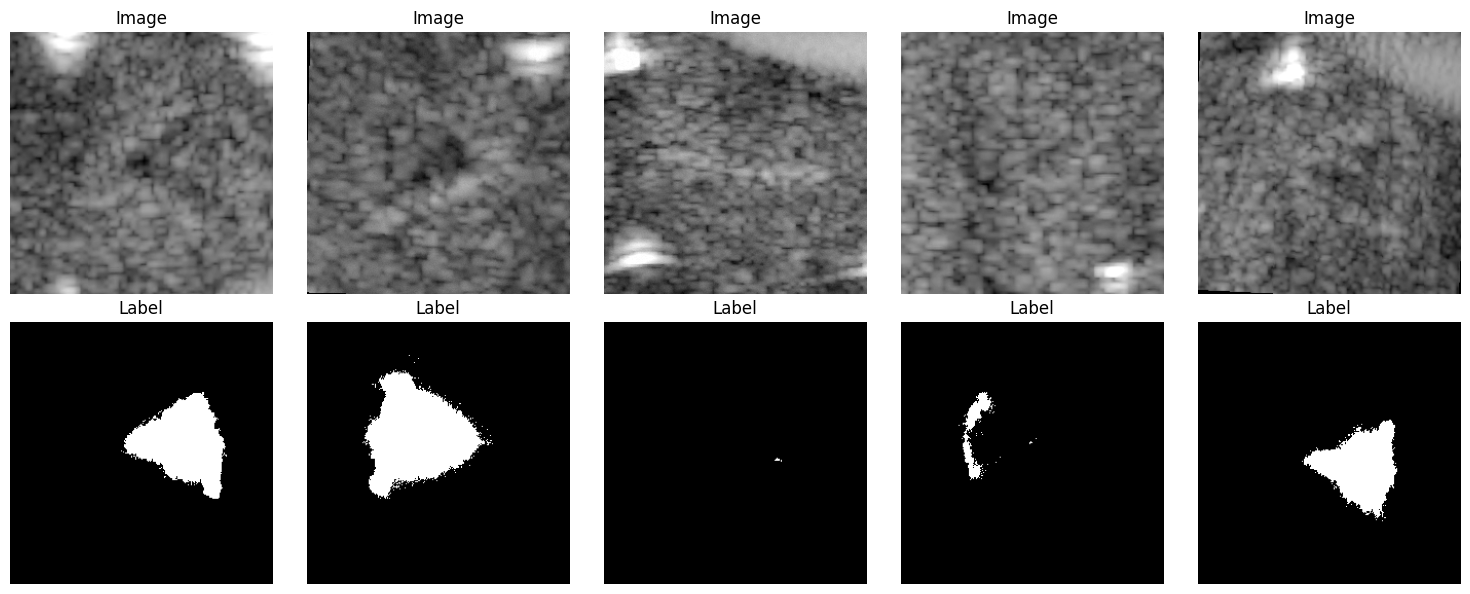

In [7]:
def show_images(img_batch, lbl_batch, num_samples=5):
    plt.figure(figsize=(num_samples * 3, 6))

    for i in range(num_samples):
        img = img_batch[i][0].cpu().numpy()  # take 1st channel directly (no permute needed)
        lbl = lbl_batch[i].cpu().numpy()

        # Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("Image")

        # Label
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(lbl, cmap='gray')
        plt.axis('off')
        plt.title("Label")

    plt.tight_layout()
    plt.show()

img_batch, lbl_batch = next(iter(train_loader))
show_images(img_batch, lbl_batch)


--- Dataset 1 ---


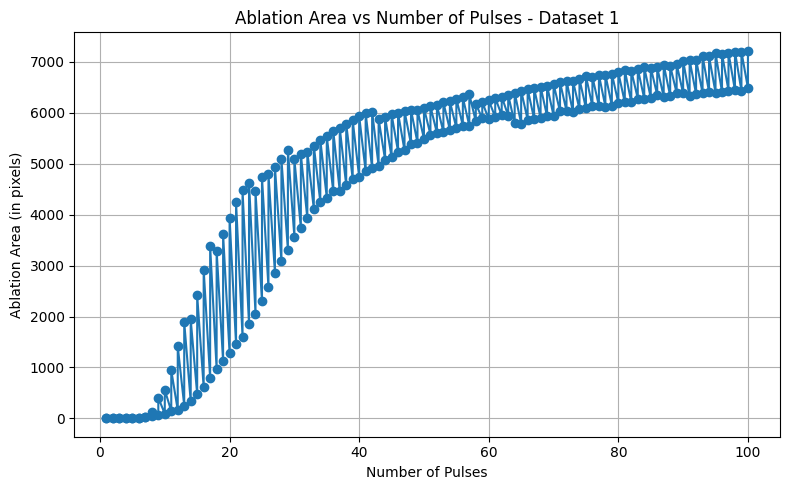


--- Dataset 2 ---


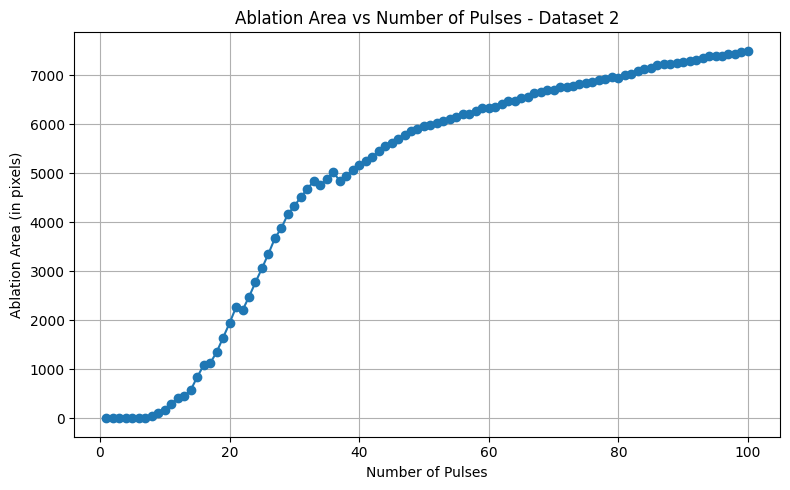


--- Dataset 3 ---


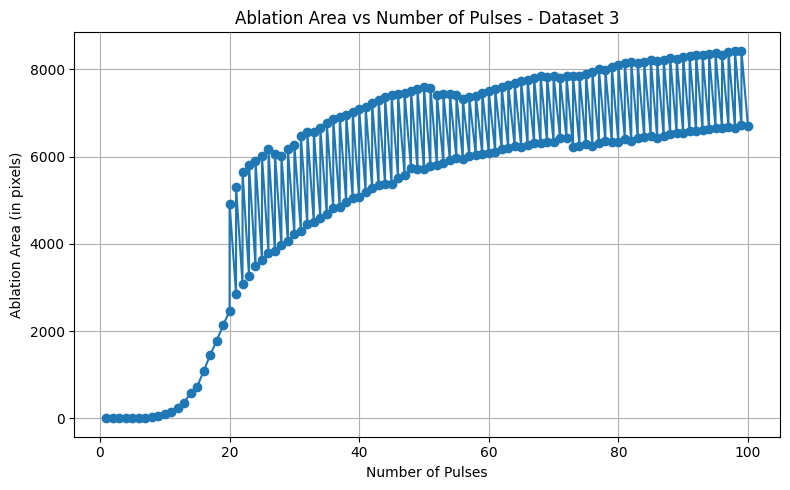


--- Dataset 4 ---


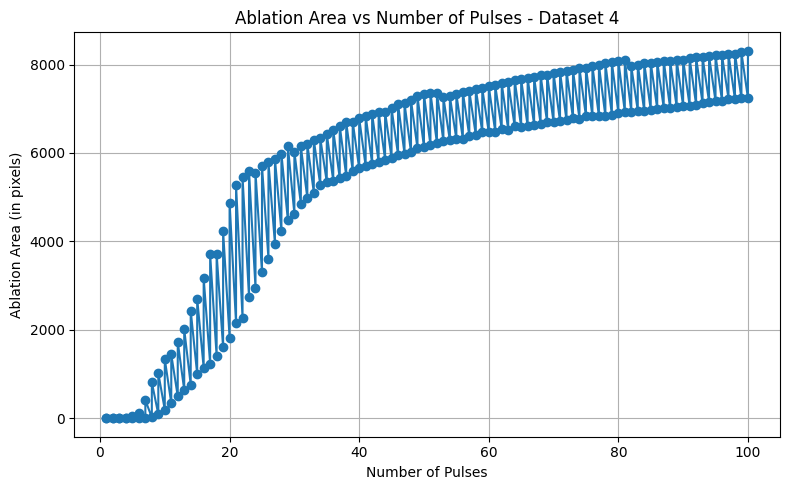


--- Dataset 5 ---


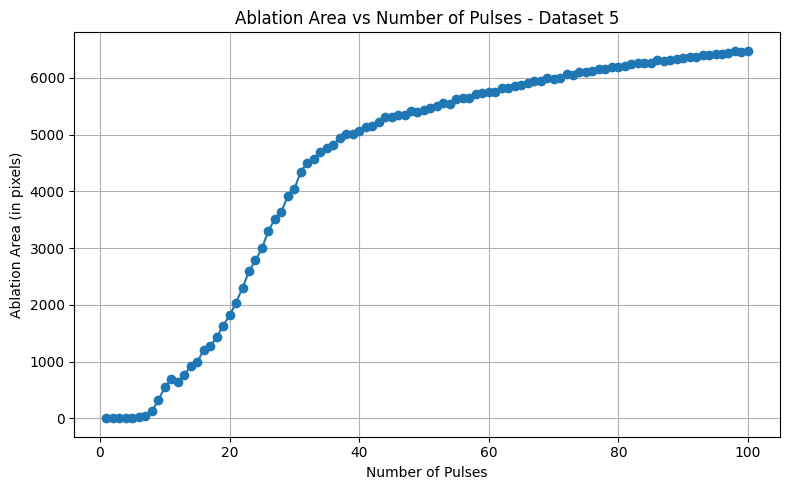


--- Dataset 6 ---


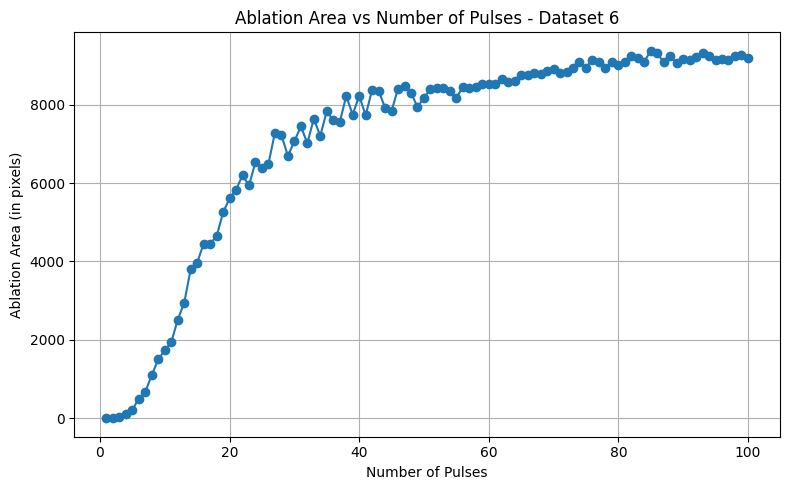

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

for dataset_num in range(1, 7):
    print(f"\n--- Dataset {dataset_num} ---")

    dataset_images = [img for img in all_images if extract_dataset_number(img) == dataset_num]
    dataset_labels = [lbl for lbl in all_labels if extract_dataset_number(lbl) == dataset_num]

    # Sort both for consistent pairing
    dataset_images = sorted(dataset_images, key=extract_pulse_number)
    dataset_labels = sorted(dataset_labels, key=extract_pulse_number)

    if not dataset_labels:
        # print(f"No labels found for dataset {dataset_num}")
        continue
    # Calculate ablation area
    pulse_area = []

    for lbl_path in dataset_labels:
        pulse_num = extract_pulse_number(lbl_path)
        if pulse_num == -1:
            continue

        lbl_img = Image.open(lbl_path).convert('L')  # Convert to grayscale
        lbl_img = lbl_img.resize((256, 256), resample=Image.NEAREST)
        lbl_array = np.array(lbl_img)

        area = np.count_nonzero(lbl_array)
        pulse_area.append((pulse_num, area))

    if not pulse_area:
        print(f"No valid pulse data for dataset {dataset_num}")
        continue

    # Sort by pulse number
    pulse_area.sort(key=lambda x: x[0])
    pulse_nums, areas = zip(*pulse_area)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(pulse_nums, areas, marker='o')
    plt.xlabel("Number of Pulses")
    plt.ylabel("Ablation Area (in pixels)")
    plt.title(f"Ablation Area vs Number of Pulses - Dataset {dataset_num}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import os, glob, re
import numpy as np
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

# ---- Loss Functions ----
class AsymmetricTverskyLoss(nn.Module):
    def __init__(self, delta=0.7, smooth=1e-6, class_weights=None):
        """
        delta > 0.5 penalizes false negatives more (good for segmentation)
        class_weights: tensor of shape (num_classes,), e.g., [background_weight, foreground_weight]
        """
        super().__init__()
        self.delta = delta
        self.smooth = smooth
        self.class_weights = class_weights

    def forward(self, preds, targets):
        # preds shape: (batch, num_classes, H, W)
        preds = F.softmax(preds, dim=1)  # probability over classes

        # Assume binary segmentation: background (0), foreground (1)
        foreground_preds = preds[:, 1, :, :]  # shape: (batch, H, W)
        background_preds = preds[:, 0, :, :]  # shape: (batch, H, W)

        foreground_targets = (targets == 1).float()
        background_targets = (targets == 0).float()

        # True Positives, False Negatives, False Positives for foreground
        true_pos_fg  = (foreground_preds * foreground_targets).sum(dim=[1, 2])
        false_neg_fg = (foreground_targets * (1 - foreground_preds)).sum(dim=[1, 2])
        false_pos_fg = ((1 - foreground_targets) * foreground_preds).sum(dim=[1, 2])

        # True Positives, False Negatives, False Positives for background (optional)
        true_pos_bg  = (background_preds * background_targets).sum(dim=[1, 2])
        false_neg_bg = (background_targets * (1 - background_preds)).sum(dim=[1, 2])
        false_pos_bg = ((1 - background_targets) * background_preds).sum(dim=[1, 2])

        # Tversky index for foreground and background
        tversky_fg = (true_pos_fg + self.smooth) / (true_pos_fg + self.delta * false_neg_fg + (1 - self.delta) * false_pos_fg + self.smooth)
        tversky_bg = (true_pos_bg + self.smooth) / (true_pos_bg + self.delta * false_neg_bg + (1 - self.delta) * false_pos_bg + self.smooth)

        if self.class_weights is not None:
            # Weighted sum of background and foreground losses
            loss = (1 - tversky_bg) * self.class_weights[0] + (1 - tversky_fg) * self.class_weights[1]
        else:
            # Just use foreground loss if no class weights given
            loss = 1 - tversky_fg

        return loss  # shape: (batch,)

class FocalLossA(nn.Module):
    def __init__(self, gamma=2, reduction='none'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')  # always 'none' internally

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)  # (batch, H, W)
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** self.gamma * ce_loss

        # Apply reduction manually
        if self.reduction == 'mean':
            return focal.mean()
        elif self.reduction == 'sum':
            return focal.sum()
        else:  # 'none' – average over spatial dims per sample
            focal = focal.view(focal.shape[0], -1).mean(dim=1)
            return focal
    


class AsymmetricFocalTverskyLoss(nn.Module):
    def __init__(self, tversky_weight=0.5, focal_weight=0.5, delta=0.3):
        super().__init__()
        self.tversky = AsymmetricTverskyLoss(delta=delta)
        self.focal = FocalLossA(gamma=2, reduction='none')
        self.tversky_weight = tversky_weight
        self.focal_weight = focal_weight


    def forward(self, preds, targets):
        # Compute per-sample losses
        tversky_loss = self.tversky(preds, targets)  # shape: (batch,)
        focal_loss = self.focal(preds, targets)      # shape: (batch,)
        # Weighted sum of the two losses
        loss = self.tversky_weight * tversky_loss + self.focal_weight * focal_loss
        return loss.mean()  # Return the average over the batch
    def forward_map(self, logits, targets):
        # Apply sigmoid to logits to get probabilities (shape: batch_size, H, W)
        probs = torch.sigmoid(logits)
    
        # Ensure the targets have the same shape as probs
        if targets.ndimension() == 3:  # If targets is (batch, H, W)
            targets = targets.unsqueeze(1)  # Add channel dimension, shape becomes (batch, 1, H, W)
    
        # Now `probs` and `targets` are both (batch, 1, H, W) for binary segmentation
        intersection = (probs * targets).sum(dim=[1, 2, 3])  # Sum over H, W dimensions
        fp = ((1 - targets) * probs).sum(dim=[1, 2, 3])
        fn = (targets * (1 - probs)).sum(dim=[1, 2, 3])
    
        # Compute Tversky index (foreground, binary segmentation)
        tversky = (intersection + self.smooth) / (intersection + self.delta * fn + (1 - self.delta) * fp + self.smooth)
    
        # Focal loss part, weighted by (1 - tversky)
        loss = (1 - tversky) ** self.gamma
        return loss  # shape: (batch_size, H, W)



In [10]:
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)[:, 1, :, :]  # Use class 1 (foreground)
        targets = (targets == 1).float()
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss()

    def forward(self, preds, targets):
        ce_loss = self.ce(preds, targets)
        pt = torch.exp(-ce_loss)
        focal = (1 - pt) ** self.gamma * ce_loss
        return focal

class DiceFocalLoss(nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.5):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def forward(self, preds, targets):
        return self.dice_weight * self.dice(preds, targets) + self.focal_weight * self.focal(preds, targets)

import torch
import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff
import numpy as np

# --- IoU ---
def compute_iou(preds, targets):
    # preds & targets : shape (B, H, W) ; values {0,1}
    intersection = (preds & targets).float().sum((1, 2))
    union = (preds | targets).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)  # per-sample IoU
    return iou.mean().item()

# --- Dice Coefficient ---
def compute_dice(preds, targets):
    intersection = (preds & targets).float().sum((1, 2))
    dice = (2 * intersection + 1e-6) / (preds.float().sum((1, 2)) + targets.float().sum((1, 2)) + 1e-6)
    return dice.mean().item()

# --- Hausdorff Distance ---
def compute_hausdorff(preds, targets):
    # preds & targets: shape (B, H, W)
    hausdorff_list = []
    preds_np = preds.cpu().numpy()
    targets_np = targets.cpu().numpy()

    for pred, target in zip(preds_np, targets_np):
        pred_pts = np.argwhere(pred)
        target_pts = np.argwhere(target)
        if len(pred_pts) == 0 or len(target_pts) == 0:
            hausdorff_list.append(0.0)
        else:
            d1 = directed_hausdorff(pred_pts, target_pts)[0]
            d2 = directed_hausdorff(target_pts, pred_pts)[0]
            hausdorff_list.append(max(d1, d2))

    return np.mean(hausdorff_list)

In [14]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
weights = DeepLabV3_ResNet101_Weights.DEFAULT

try:
    from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
    weights = DeepLabV3_ResNet101_Weights.DEFAULT

    model = deeplabv3_resnet101(weights=weights)
    model.classifier[4] = nn.Conv2d(256, 2, kernel_size=1)
    model = model.cuda()
    print("✅ Model successfully moved to CUDA")
except Exception as e:
    print("❌ CUDA error during model setup:", e)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 160MB/s]  


✅ Model successfully moved to CUDA


In [15]:
import numpy as np

def compute_segmentation_metrics(preds, targets, num_classes):
    """
    Computes per-class IoU, per-class Accuracy, Global Accuracy,
    Mean Accuracy, Mean IoU, and Weighted IoU following MATLAB's
    evaluateSemanticSegmentation conventions.

    preds and targets should be numpy arrays of shape (B, H, W) with integer class labels.
    """
    # ensure numpy arrays
    preds = np.asarray(preds, dtype=np.int32)
    targets = np.asarray(targets, dtype=np.int32)

    class_iou = []
    class_accuracy = []
    supports = []

    # 1. Per-class metrics
    for cls in range(num_classes):
        pred_inds   = (preds == cls)
        target_inds = (targets == cls)

        tp = np.sum(pred_inds & target_inds)
        fp = np.sum(pred_inds & ~target_inds)
        fn = np.sum(~pred_inds & target_inds)

        # IoU = TP / (TP + FP + FN)
        iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else np.nan
        class_iou.append(iou)

        # Accuracy = TP / (TP + FN)
        acc = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        class_accuracy.append(acc)

        # support = number of GT pixels in this class
        supports.append(np.sum(target_inds))

    # 2. Global Accuracy
    total_correct   = np.sum(preds == targets)
    total_pixels    = preds.size
    global_accuracy = total_correct / total_pixels if total_pixels > 0 else np.nan

    # 3. Mean metrics (ignore NaNs)
    mean_iou      = np.nanmean(class_iou)
    mean_accuracy = np.nanmean(class_accuracy)

    # 4. Weighted IoU (support‑weighted)
    if sum(supports) > 0:
        weighted_iou = sum(supports[c] * class_iou[c] for c in range(num_classes)) / sum(supports)
    else:
        weighted_iou = np.nan

    return {
        'per_class_iou':       class_iou,
        'mean_iou':            mean_iou,
        'weighted_iou':        weighted_iou,
        'per_class_accuracy':  class_accuracy,
        'mean_accuracy':       mean_accuracy,
        'global_accuracy':     global_accuracy
    }

In [17]:
import os
import yaml
from tqdm import tqdm
import numpy as np
import torch
from datetime import datetime

# --- IoU ---

num_classes =2
# === Config Params === #
experiment_name = f"BubbleSeg"
save_dir = os.path.join("/kaggle/working/checkpoints", experiment_name)
os.makedirs(save_dir, exist_ok=True)

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# === Training Setup === #
# criterion = DiceFocalLoss(dice_weight=0.5, focal_weight=0.6)
class_weights = torch.tensor([0.4, 0.6])
criterion = AsymmetricFocalTverskyLoss(
    tversky_weight=0.7,
    focal_weight=0.3,
    delta=0.7
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,         # Smaller learning rate for pre-trained backbone
    weight_decay=1e-4
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',             # we want to maximize validation IoU
    factor=0.9,             # reduce LR by half
    patience=4,             # wait 4 epochs before reducing LR
    verbose=True,
    min_lr=1e-6             # don’t go too low
)

params = {
    'model': 'D',
    'criterion': 'D0.50.6',
    'optimizer': 'Adam',
    'lr': 1e-4,
    'scheduler': 'ReduceLROnPlateau',
    'num_epochs': 5
}
with open(os.path.join(save_dir, "/kaggle/working/initial_config.yaml"), 'w') as f:
    yaml.dump(params, f)


num_epochs = 10
best_val_iou = 0
val_iou = 0.0
val_acc = 0.0
val_global_acc = 0.0
val_weighted_iou = 0.0

for epoch in range(num_epochs):
    model.train()
    # if epoch < 5:
    #   for param in model.backbone.parameters():
    #     param.requires_grad = False
    #   else:
    #     for param in model.backbone.parameters():
    #         param.requires_grad = True
    train_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
    for imgs, masks in train_loop:
        imgs, masks = imgs.cuda(), masks.cuda()

        optimizer.zero_grad()
        outputs = model(imgs)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader)

    # === Validation === #
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_weighted_iou = 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validating", leave=False):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            # val_iou += compute_class_iou(preds.cpu(), masks.cpu(), num_classes=num_classes)['mean_iou']

            batch_metrics = compute_segmentation_metrics(preds.cpu(), masks.cpu(), num_classes=num_classes)

            val_iou += batch_metrics['mean_iou']
            val_acc += batch_metrics['mean_accuracy']
            val_global_acc += batch_metrics['global_accuracy']
            val_weighted_iou += batch_metrics['weighted_iou']

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    avg_val_accuracy = val_acc / len(val_loader)
    avg_global_accuracy = val_global_acc / len(val_loader)
    avg_weighted_iou = val_weighted_iou / len(val_loader)

    print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f} | Val IoU = {avg_val_iou:.4f} | Weighted IoU = {  avg_weighted_iou:.4f}")

    scheduler.step(avg_val_iou)

    # === Save per epoch === #
    torch.save(model.state_dict(), os.path.join(save_dir, f"epoch_{epoch+1}.pth"))

    # === Save best model === #
    if avg_val_iou > best_val_iou :
        best_val_iou = avg_val_iou
        if best_val_iou > 0.76:
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model_{best_val_iou:.2f}.pth"))
            print(" Best model saved!")

# === Save Final model === #
torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))
print(" Final model saved.")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 Epoch 1: Train Loss = 0.4184 | Val Loss = 0.3913 | Val IoU = 0.5164 | Weighted IoU = 0.6897
 Best model saved!


 Epoch 2: Train Loss = 0.2885 | Val Loss = 0.3583 | Val IoU = 0.7204 | Weighted IoU = 0.9000
 Best model saved!


 Epoch 3: Train Loss = 0.2460 | Val Loss = 0.3083 | Val IoU = 0.7444 | Weighted IoU = 0.9122
 Best model saved!


 Epoch 4: Train Loss = 0.2225 | Val Loss = 0.3300 | Val IoU = 0.7678 | Weighted IoU = 0.9285
 Best model saved!


 Epoch 5: Train Loss = 0.2027 | Val Loss = 0.2643 | Val IoU = 0.8074 | Weighted IoU = 0.9408
 Best model saved!


 Epoch 6: Train Loss = 0.1856 | Val Loss = 0.3155 | Val IoU = 0.7537 | Weighted IoU = 0.9197


 Epoch 7: Train Loss = 0.1773 | Val Loss = 0.3151 | Val IoU = 0.7255 | Weighted IoU = 0.9071


 Epoch 8: Train Loss = 0.1644 | Val Loss = 0.2936 | Val IoU = 0.7660 | Weighted IoU = 0.9264


 Epoch 9: Train Loss = 0.1586 | Val Loss = 0.2654 | Val IoU = 0.7824 | Weighted IoU = 0.9306


 Epoch 10: Train Loss = 0.1495 | Val Loss = 0.2880 | Val IoU = 0.7819 | Weighted IoU = 0.9340
 Final model saved.


In [20]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
import numpy as np
import torch
import re
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

def extract_pulse_and_dataset(filename):
    """
    Extracts:
    - pulse number from 'US###'
    - dataset number as the last number before '.jpg'
    Example: 't3US100_738983_1.jpg' → pulse=100, dataset=1
    """
    base = os.path.basename(filename).replace(".jpg", "")
    parts = base.split('_')
    dataset = int(parts[-1]) if parts[-1].isdigit() else -1
    pulse_match = re.search(r'US(\d+)', base)
    pulse = int(pulse_match.group(1)) if pulse_match else -1
    return pulse, dataset

# STEP 1: Create test dataset
test_images = sorted(glob.glob('/kaggle/working/BubbleSegmentation/Data/US_Test_2023April7/*.jpg'))
test_labels = sorted(glob.glob('/kaggle/working/BubbleSegmentation/Data/Label_Test_2023April7/*.png'))

test_dataset = BubbleDataset(test_images, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=False)

print(len(test_loader))

25


In [21]:
# Directory where all model checkpoints are saved
model_dir = "/kaggle/working/checkpoints/BubbleSeg"
model_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".pth")])

results = []

print("Evaluating all saved models...")
for model_file in tqdm(model_files, desc="Evaluating models"):
    model_path = os.path.join(model_dir, model_file)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    total_iou = 0.0
    total_weighted_iou = 0.0
    total_accuracy = 0.0
    total_global_acc = 0.0
    count = 0

    with torch.no_grad():
        for imgs, masks in test_loader:
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)['out']
            preds = torch.argmax(outputs, dim=1)

            metrics = compute_segmentation_metrics(preds.cpu(), masks.cpu(), num_classes=num_classes)
            total_iou += metrics['mean_iou']
            total_weighted_iou += metrics['weighted_iou']
            total_accuracy += metrics['mean_accuracy']
            total_global_acc += metrics['global_accuracy']
            count += 1

    avg_iou = total_iou / count
    avg_weighted_iou = total_weighted_iou / count
    avg_acc = total_accuracy / count
    avg_global = total_global_acc / count

    print(f"{model_file} | IoU: {avg_iou:.4f} | Weighted IoU: {avg_weighted_iou:.4f} | Accuracy: {avg_acc:.4f} | Global Acc: {avg_global:.4f}")
    results.append({
        "model": model_file,
        "IoU": avg_iou,
        "Weighted IoU": avg_weighted_iou,
        "Accuracy": avg_acc,
        "Global Accuracy": avg_global
    })

# Optional: Save results as CSV
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(model_dir, "model_evaluation_results.csv"), index=False)
print("Saved evaluation results to CSV.")
display(results_df)

Evaluating all saved models...


Evaluating models:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipykernel_31/2813327277.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

best_model_0.5.pth | IoU: 0.5536 | Weighted IoU: 0.6685 | Accuracy: 0.8155 | Global Acc: 0.7182


Evaluating models:  14%|█▍        | 2/14 [00:34<03:25, 17.13s/it]

best_model_0.7.pth | IoU: 0.7779 | Weighted IoU: 0.9205 | Accuracy: 0.8664 | Global Acc: 0.9542


Evaluating models:  21%|██▏       | 3/14 [00:51<03:10, 17.33s/it]

best_model_0.8.pth | IoU: 0.7903 | Weighted IoU: 0.9302 | Accuracy: 0.8437 | Global Acc: 0.9611


Evaluating models:  29%|██▊       | 4/14 [01:09<02:52, 17.29s/it]

epoch_1.pth | IoU: 0.5536 | Weighted IoU: 0.6685 | Accuracy: 0.8155 | Global Acc: 0.7182


Evaluating models:  36%|███▌      | 5/14 [01:25<02:34, 17.18s/it]

epoch_10.pth | IoU: 0.7712 | Weighted IoU: 0.9240 | Accuracy: 0.8222 | Global Acc: 0.9585


Evaluating models:  43%|████▎     | 6/14 [01:42<02:16, 17.12s/it]

epoch_2.pth | IoU: 0.7707 | Weighted IoU: 0.9143 | Accuracy: 0.8712 | Global Acc: 0.9486


Evaluating models:  50%|█████     | 7/14 [02:00<02:00, 17.15s/it]

epoch_3.pth | IoU: 0.7779 | Weighted IoU: 0.9205 | Accuracy: 0.8664 | Global Acc: 0.9542


Evaluating models:  57%|█████▋    | 8/14 [02:17<01:43, 17.17s/it]

epoch_4.pth | IoU: 0.7721 | Weighted IoU: 0.9234 | Accuracy: 0.8252 | Global Acc: 0.9578


Evaluating models:  64%|██████▍   | 9/14 [02:34<01:25, 17.13s/it]

epoch_5.pth | IoU: 0.7903 | Weighted IoU: 0.9302 | Accuracy: 0.8437 | Global Acc: 0.9611


Evaluating models:  71%|███████▏  | 10/14 [02:51<01:08, 17.13s/it]

epoch_6.pth | IoU: 0.7403 | Weighted IoU: 0.9051 | Accuracy: 0.8252 | Global Acc: 0.9432


Evaluating models:  79%|███████▊  | 11/14 [03:08<00:51, 17.16s/it]

epoch_7.pth | IoU: 0.7218 | Weighted IoU: 0.8969 | Accuracy: 0.8149 | Global Acc: 0.9391


Evaluating models:  86%|████████▌ | 12/14 [03:26<00:34, 17.26s/it]

epoch_8.pth | IoU: 0.7802 | Weighted IoU: 0.9264 | Accuracy: 0.8376 | Global Acc: 0.9596


Evaluating models:  93%|█████████▎| 13/14 [03:43<00:17, 17.26s/it]

epoch_9.pth | IoU: 0.7919 | Weighted IoU: 0.9328 | Accuracy: 0.8354 | Global Acc: 0.9639


Evaluating models: 100%|██████████| 14/14 [04:00<00:00, 17.20s/it]

last_model.pth | IoU: 0.7712 | Weighted IoU: 0.9240 | Accuracy: 0.8222 | Global Acc: 0.9585


Saved evaluation results to CSV.


,model,IoU,Weighted IoU,Accuracy,Global Accuracy
0,best_model_0.5.pth,0.553625,0.668463,0.815511,0.718190
1,best_model_0.7.pth,0.777899,0.920471,0.866389,0.954179
2,best_model_0.8.pth,0.790295,0.930203,0.843660,0.961126
3,epoch_1.pth,0.553625,0.668463,0.815511,0.718190
4,epoch_10.pth,0.771217,0.924023,0.822180,0.958487
5,epoch_2.pth,0.770659,0.914274,0.871207,0.948624
6,epoch_3.pth,0.777899,0.920471,0.866389,0.954179
7,epoch_4.pth,0.772146,0.923424,0.825200,0.957763
8,epoch_5.pth,0.790295,0.930203,0.843660,0.961126
9,epoch_6.pth,0.740302,0.905085,0.825196,0.943167


In [22]:
import os
import shutil

# Define the source and destination directories
source_dir = "/kaggle/working/checkpoints/BubbleSeg"
destination_dir = "/kaggle/working/models_to_download"

# Create destination folder if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop through the files in the source directory and copy models starting with 'best_model_'
for filename in os.listdir(source_dir):
    if filename.startswith("best_model_"):
        # Define full file paths
        source_file = os.path.join(source_dir, filename)
        destination_file = os.path.join(destination_dir, filename)
        
        # Copy file to destination folder
        shutil.copy(source_file, destination_file)

print("Models copied to:", destination_dir)

Models copied to: /kaggle/working/models_to_download


In [23]:
def compute_area(mask):
    return (mask == 1).sum().item()


def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=None, idx=None):
    img = img_tensor.cpu()
    pred = pred_mask.cpu().numpy()
    true = true_mask.cpu().numpy()

    if original_img_size is not None:
        H, W = original_img_size
        pred = TF.resize(torch.tensor(pred).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        true = TF.resize(torch.tensor(true).unsqueeze(0).unsqueeze(0).float(), size=[H, W], interpolation=transforms.InterpolationMode.NEAREST).squeeze().numpy()
        img = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img[0], cmap='gray')
    axes[0].set_title('Input Image')
    axes[1].imshow(pred, cmap='gray')
    axes[1].set_title('Predicted Mask')
    axes[2].imshow(true, cmap='gray')
    axes[2].set_title('Ground Truth')

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Load best model === #
model.load_state_dict(torch.load("/kaggle/working/checkpoints/BubbleSeg/best_model.pth"))
model.eval()

import os
from tqdm import tqdm
import torch
import torch.nn.functional as F
import numpy as np


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# assume compute_segmentation_metrics is already imported
# from your_metrics_module import compute_segmentation_metrics

# === Run on test_loader === #
records = []
all_mean_ious     = []
all_weighted_ious = []
n_visualize = 5  # if you still want to visualize the first n images

with torch.no_grad():
    for idx, (imgs, masks) in enumerate(tqdm(test_loader, desc="Evaluating on Test")):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)

        # if your preds need to be resized to match masks:
        if preds.shape != masks.shape:
            preds = F.interpolate(
                preds.unsqueeze(1).float(),
                size=masks.shape[-2:],
                mode='nearest'
            ).squeeze(1).long()

        # --- compute MATLAB‑style metrics per batch (or per image) ---
        # here we do it per-batch and then split per-image below
        batch_metrics = compute_segmentation_metrics(
            preds.cpu().numpy(),
            masks.cpu().numpy(),
            num_classes=2
        )

        # collect for final reporting:
        all_mean_ious.append(batch_metrics['mean_iou'])
        all_weighted_ious.append(batch_metrics['weighted_iou'])

        # --- unpack per-image (optional) and record other stats ---
        B = imgs.size(0)
        for i in range(B):
            image_idx = idx * test_loader.batch_size + i
            image_name = os.path.basename(test_images[image_idx])
            pulse, dataset = extract_pulse_and_dataset(image_name)

            gt_area   = compute_area(masks[i].cpu())
            pred_area = compute_area(preds[i].cpu())

            # if you want per-image IoU/Acc you could call compute_segmentation_metrics
            # on the single image pair here:
            # img_metrics = compute_segmentation_metrics(
            #     preds[i:i+1].cpu().numpy(),
            #     masks[i:i+1].cpu().numpy(),
            #     num_classes=2
            # )

            records.append({
                'image':           image_name,
                'pulse':           pulse,
                'dataset':         dataset,
                'gt_area_px':      gt_area,
                'pred_area_px':    pred_area,
                # 'image_mean_iou':  img_metrics['mean_iou'],
                # 'image_weighted_iou': img_metrics['weighted_iou'],
            })

# --- Final aggregated metrics --- #
final_mean_iou     = np.mean(all_mean_ious)
final_weighted_iou = np.mean(all_weighted_ious)

print(f"Mean IoU (unweighted)   : {final_mean_iou:.4f}")
print(f"Weighted IoU (support)  : {final_weighted_iou:.4f}")

# === Convert to DataFrame ===
df = pd.DataFrame(records)

# Convert to mm² using correct scaling
pixel_area_mm2 = 0.005
df['gt_area_mm2'] = df['gt_area_px'] * pixel_area_mm2
df['pred_area_mm2'] = df['pred_area_px'] * pixel_area_mm2

# === Show first few entries for verification ===
print(" Evaluation complete. Sample entries:")
display(df.head())

# === Save to CSV ===
df.to_csv("gt_pred_areas_per_image.csv", index=False)
print(" Saved: gt_pred_areas_per_image.csv")

# === Optional: Group by (pulse, dataset) for plotting later ===
grouped_df = df.groupby(['pulse', 'dataset'])[['gt_area_mm2', 'pred_area_mm2']].mean().reset_index()
grouped_df.to_csv("area_grouped_by_pulse_dataset.csv", index=False)
print(" Saved: area_grouped_by_pulse_dataset.csv")

display(grouped_df)

# Group by pulse and calculate mean and std across datasets
pulse_agg = df.groupby('pulse')[['gt_area_mm2', 'pred_area_mm2']].agg(['mean', 'std']).reset_index()

# Flatten column names
pulse_agg.columns = ['pulse',
                     'gt_mean', 'gt_std',
                     'pred_mean', 'pred_std']
display(pulse_agg)

pulse_agg['pulse'] = pulse_agg['pulse'].astype(int)*20
import matplotlib.pyplot as plt
import pandas as pd


# Plot setup
plt.figure(figsize=(12, 6))

# Plot ground truth mean and std
plt.plot(pulse_agg['pulse'], pulse_agg['gt_mean'], label='Ground Truth Mean', color='orange')
plt.fill_between(pulse_agg['pulse'],
                 pulse_agg['gt_mean'] - pulse_agg['gt_std'],
                 pulse_agg['gt_mean'] + pulse_agg['gt_std'],
                 alpha=0.3, color='orange', label='Ground Truth ± Std')

# Plot predicted mean and std
plt.plot(pulse_agg['pulse'], pulse_agg['pred_mean'], label='Predicted Mean', color='blue')
plt.fill_between(pulse_agg['pulse'],
                 pulse_agg['pred_mean'] - pulse_agg['pred_std'],
                 pulse_agg['pred_mean'] + pulse_agg['pred_std'],
                 alpha=0.3, color='blue', label='Predicted ± Std')

# Labels and legend
plt.xlabel('Number of Pulses')
plt.ylabel('Mean Values')
plt.title('Ground Truth vs Predicted Mean and Std')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_31/39093426.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/checkpoints/BubbleSeg/best_model.pth"))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/checkpoints/BubbleSeg/best_model.pth'

In [ ]:
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("/kaggle/working/checkpoints/BubbleSeg/best_model.pth"))
model.eval()

# --- Visualize Predictions ---
def visualize_prediction(img_tensor, pred_mask, true_mask, original_img_size=(256, 1024), idx=None, pulse = None):
    img = img_tensor.cpu().detach()
    pred = pred_mask.cpu().detach()
    true = true_mask.cpu().detach()


    H, W = original_img_size

    # Resize predictions and labels back to original size
    pred_resized = TF.resize(
        pred.unsqueeze(0).unsqueeze(0).float(),
        size=[H, W],
        interpolation=transforms.InterpolationMode.NEAREST
    ).squeeze(0).squeeze(0).long().numpy()

    true_resized = TF.resize(
        true.unsqueeze(0).unsqueeze(0).float(),
        size=[H, W],
        interpolation=transforms.InterpolationMode.NEAREST
    ).squeeze(0).squeeze(0).long().numpy()

    img_resized = TF.resize(img, size=[H, W], interpolation=transforms.InterpolationMode.BILINEAR)

    # Prepare image for imshow
    if img_resized.ndim == 3:
        if img_resized.shape[0] == 1:
            img_disp = img_resized.squeeze(0).numpy()  # Grayscale
        else:
            img_disp = img_resized.permute(1, 2, 0).numpy()  # CHW to HWC
    else:
        img_disp = img_resized.numpy()

    # Plotting
    dpi = 100
    fig_width = W / dpi * 3
    fig_height = H / dpi

    fig, axes = plt.subplots(1, 3, figsize=(fig_width, fig_height), dpi=dpi)

    axes[0].imshow(img_disp, cmap='gray' if img_disp.ndim == 2 else None)
    axes[0].set_title(f'B-Mode Image - {pulse}', fontsize = 16)

    axes[1].imshow(pred_resized, cmap='gray')
    axes[1].set_title('Predicted Mask', fontsize = 16)

    axes[2].imshow(true_resized, cmap='gray')
    axes[2].set_title('Ground Truth', fontsize = 16)



    for ax in axes:
        ax.axis('off')

    plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05)
    plt.tight_layout()

    if idx is not None:
        plt.savefig(f"prediction_{idx}.png", dpi=dpi, bbox_inches='tight')

    plt.show()


# Wrapper with correct original image size
def plot_image_gt_pred(img, gt, pred, idx=None, pulse = None):
    visualize_prediction(img, pred, gt, original_img_size=(256, 1024), idx=idx, pulse=pulse)


# --- Reload a few batches for visualization ---
visual_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

model.eval()
with torch.no_grad():
    for idx, (imgs, masks) in enumerate(visual_loader):
        imgs, masks = imgs.cuda(), masks.cuda()
        outputs = model(imgs)['out']
        preds = torch.argmax(outputs, dim=1)
        image_name = os.path.basename(test_images[idx * visual_loader.batch_size + i])
        label_name = os.path.basename(test_labels[idx * visual_loader.batch_size + i])
        pulse, dataset = extract_pulse_and_dataset(image_name)
        for i in range(min(imgs.size(0), 6)):
            img = imgs[i]
            gt = masks[i]
            pred = preds[i]

            # Optional safety resize (if needed)
            if pred.shape != gt.shape:
                pred = F.interpolate(
                    pred.unsqueeze(0).unsqueeze(0).float(),
                    size=gt.shape[-2:],
                    mode='nearest'
                ).squeeze().long()

            plot_image_gt_pred(img, gt, pred, i, pulse)

        break  # visualize only one batch


In [ ]:
import shutil
import zipfile
import os

# Define paths
best_model_path = os.path.join(save_dir, "best_model.pth")
config_file_path = os.path.join(save_dir, "initial_config.yaml")
zip_file_path = '/kaggle/working/bubbleseg_model_and_config.zip'

# Create a zip file containing the best model and config file
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    zipf.write(best_model_path, 'best_model.pth')
    zipf.write(config_file_path, 'initial_config.yaml')

# Output the path for downloading
print(f"✅ Files have been zipped and saved at {zip_file_path}. You can download the file from here.")


In [25]:
import os
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

def objective(trial):
    # Suggest hyperparameters for asymmetric Tversky loss
    tversky_weight = trial.suggest_float('tversky_weight', 0.5, 0.9)
    focal_weight = trial.suggest_float('focal_weight', 0.1, 0.5)
    delta = trial.suggest_float('delta', 0.5, 0.9)

    print(tversky_weight , focal_weight,delta)

    # Update criterion with the suggested hyperparameters
    criterion = AsymmetricFocalTverskyLoss(
        tversky_weight=tversky_weight,
        focal_weight=focal_weight,
        delta=delta
    )

    # Initialize model and optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=1e-4,
        weight_decay=1e-4
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.9,
        patience=4,
        verbose=True,
        min_lr=1e-6
    )
    
    # Create save directory if it doesn't exist
    # best_model_dir = "/path/to/save_best_model"  # Specify your path
    os.makedirs(best_model_dir, exist_ok=True)
    
    num_epochs = 5
    best_val_iou = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        
        # Training loop with tqdm progress bar
        for imgs, masks in train_loop:
            imgs, masks = imgs.cuda(), masks.cuda()
            optimizer.zero_grad()
            outputs = model(imgs)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())  # Display training loss in progress bar

        avg_train_loss = train_loss / len(train_loader)

        # === Validation === #
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_acc = 0.0
        val_global_acc = 0.0
        val_weighted_iou = 0.0
        val_loop = tqdm(val_loader, desc="Validating", leave=False)
        
        # Validation loop with tqdm progress bar
        with torch.no_grad():
            for imgs, masks in val_loop:
                imgs, masks = imgs.cuda(), masks.cuda()
                outputs = model(imgs)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                batch_metrics = compute_segmentation_metrics(preds.cpu(), masks.cpu(), num_classes=num_classes)
                val_iou += batch_metrics['mean_iou']
                val_acc += batch_metrics['mean_accuracy']
                val_global_acc += batch_metrics['global_accuracy']
                val_weighted_iou += batch_metrics['weighted_iou']

                val_loop.set_postfix(val_loss=loss.item(), val_iou=batch_metrics['mean_iou'])

        avg_val_loss = val_loss / len(val_loader)
        avg_val_iou = val_iou / len(val_loader)
        avg_val_accuracy = val_acc / len(val_loader)
        avg_global_accuracy = val_global_acc / len(val_loader)
        avg_weighted_iou = val_weighted_iou / len(val_loader)

        # Print metrics for each epoch
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | "
              f"Val Loss = {avg_val_loss:.4f} | "
              f"Val IoU = {avg_val_iou:.4f} | "
              f"Weighted IoU = {avg_weighted_iou:.4f} | "
              f"Accuracy = {avg_val_accuracy:.4f}")

        # Update scheduler
        scheduler.step(avg_val_iou)

        # === Save best model === #
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            # Save the best model's state_dict
            torch.save(model.state_dict(), os.path.join(save_dir, f"best_model2_{best_val_iou}.pth"))
            print(f"✅ Best model saved with IoU {avg_val_iou:.4f}")

    # === Save Final model === #
    torch.save(model.state_dict(), os.path.join(save_dir, "last_model2.pth"))
    print("Final model saved.")
    
    return best_val_iou  # Return the best validation IoU for optimization


In [ ]:
# Run the Optuna study to tune the hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize the IoU
study.optimize(objective, n_trials=10)  # Run 20 trials to search for the best hyperparameters

num_classes =2
# === Config Params === #
experiment_name = f"BubbleSeg"
save_dir = os.path.join("/kaggle/working/checkpoints", experiment_name)
os.makedirs(save_dir, exist_ok=True)

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Output the best trial results
print(f"Best trial: {study.best_trial.params}")

best_params = study.best_trial.params
print("Best Tversky Weight: ", best_params['tversky_weight'])
print("Best Focal Weight: ", best_params['focal_weight'])
print("Best Delta: ", best_params['delta'])


[I 2025-04-19 08:03:59,506] A new study created in memory with name: no-name-6733356d-efee-4f6d-8b14-30733721a67d


0.6000086422788388 0.31951519305459863 0.5258635188146934


Epoch 1: Train Loss = 0.1145 | Val Loss = 0.2260 | Val IoU = 0.8257 | Weighted IoU = 0.9604 | Accuracy = 0.8657
✅ Best model saved with IoU 0.8257


Epoch 2: Train Loss = 0.1117 | Val Loss = 0.2350 | Val IoU = 0.8175 | Weighted IoU = 0.9601 | Accuracy = 0.8522


Epoch 3: Train Loss = 0.1057 | Val Loss = 0.2138 | Val IoU = 0.8404 | Weighted IoU = 0.9649 | Accuracy = 0.8795
✅ Best model saved with IoU 0.8404


Epoch 4: Train Loss = 0.1045 | Val Loss = 0.2013 | Val IoU = 0.8553 | Weighted IoU = 0.9679 | Accuracy = 0.9028
✅ Best model saved with IoU 0.8553


Epoch 5: Train Loss = 0.1017 | Val Loss = 0.2410 | Val IoU = 0.8156 | Weighted IoU = 0.9596 | Accuracy = 0.8497


[I 2025-04-19 08:11:27,143] Trial 0 finished with value: 0.8553115256245835 and parameters: {'tversky_weight': 0.6000086422788388, 'focal_weight': 0.31951519305459863, 'delta': 0.5258635188146934}. Best is trial 0 with value: 0.8553115256245835.


Final model saved.
0.8913306259154667 0.2935818101667043 0.5637540443204727


Epoch 1: Train Loss = 0.1464 | Val Loss = 0.3170 | Val IoU = 0.8337 | Weighted IoU = 0.9636 | Accuracy = 0.8742
✅ Best model saved with IoU 0.8337


Epoch 2: Train Loss = 0.1420 | Val Loss = 0.3742 | Val IoU = 0.7945 | Weighted IoU = 0.9528 | Accuracy = 0.8483


Epoch 3: Train Loss = 0.1411 | Val Loss = 0.3391 | Val IoU = 0.8253 | Weighted IoU = 0.9618 | Accuracy = 0.8712


Epoch 4: Train Loss = 0.1360 | Val Loss = 0.3780 | Val IoU = 0.7956 | Weighted IoU = 0.9539 | Accuracy = 0.8343


Epoch 5: Train Loss = 0.1379 | Val Loss = 0.3901 | Val IoU = 0.7918 | Weighted IoU = 0.9535 | Accuracy = 0.8339


[I 2025-04-19 08:18:53,527] Trial 1 finished with value: 0.8336935184644568 and parameters: {'tversky_weight': 0.8913306259154667, 'focal_weight': 0.2935818101667043, 'delta': 0.5637540443204727}. Best is trial 0 with value: 0.8553115256245835.


Final model saved.
0.8908774851125896 0.42168586495297233 0.6051463659429597


Epoch 1: Train Loss = 0.1434 | Val Loss = 0.3854 | Val IoU = 0.8015 | Weighted IoU = 0.9563 | Accuracy = 0.8340
✅ Best model saved with IoU 0.8015


Epoch 2: Train Loss = 0.1370 | Val Loss = 0.4131 | Val IoU = 0.7833 | Weighted IoU = 0.9496 | Accuracy = 0.8375


Epoch 3: Train Loss = 0.1351 | Val Loss = 0.4035 | Val IoU = 0.7884 | Weighted IoU = 0.9514 | Accuracy = 0.8357


Epoch 4: Train Loss = 0.1335 | Val Loss = 0.3749 | Val IoU = 0.8073 | Weighted IoU = 0.9570 | Accuracy = 0.8492
✅ Best model saved with IoU 0.8073


Epoch 5: Train Loss = 0.1334 | Val Loss = 0.4339 | Val IoU = 0.7845 | Weighted IoU = 0.9531 | Accuracy = 0.8139


[I 2025-04-19 08:26:19,990] Trial 2 finished with value: 0.807334229117867 and parameters: {'tversky_weight': 0.8908774851125896, 'focal_weight': 0.42168586495297233, 'delta': 0.6051463659429597}. Best is trial 0 with value: 0.8553115256245835.


Final model saved.
0.75286777776331 0.2776814505626211 0.6716834265585546


Epoch 1: Train Loss = 0.1095 | Val Loss = 0.3490 | Val IoU = 0.7845 | Weighted IoU = 0.9519 | Accuracy = 0.8206
✅ Best model saved with IoU 0.7845


Epoch 2: Train Loss = 0.1067 | Val Loss = 0.2879 | Val IoU = 0.8126 | Weighted IoU = 0.9565 | Accuracy = 0.8771
✅ Best model saved with IoU 0.8126


Epoch 3: Train Loss = 0.1074 | Val Loss = 0.3616 | Val IoU = 0.7739 | Weighted IoU = 0.9475 | Accuracy = 0.8267


Epoch 4: Train Loss = 0.1082 | Val Loss = 0.3085 | Val IoU = 0.8070 | Weighted IoU = 0.9557 | Accuracy = 0.8662


Epoch [5/5]:  72%|███████▏  | 31/43 [00:59<00:22,  1.90s/it, loss=0.0564]

In [ ]:
iou_threshold = 0.78  # Set your threshold

# Create download directory if needed
os.makedirs(download_dir, exist_ok=True)

# Loop through model files and collect good ones
for filename in os.listdir(save_dir):
    if filename.startswith("best_model2_") and filename.endswith(".pth"):
        try:
            # Extract IoU value from filename
            iou = float(filename.split("_")[-1].replace(".pth", ""))
            if iou >= iou_threshold:
                print(f"📦 Copying: {filename} (IoU: {iou:.4f})")
                shutil.copy(os.path.join(save_dir, filename), os.path.join(download_dir, filename))
        except ValueError:
            print(f"⚠️ Could not parse IoU from: {filename}")

print("✅ Finished copying good models.")